# Анализ пользовательского спроса и проверка гипотез для Яндекс Афиши

## Цели и задачи
**Цели:**
- Выявить причину общего изменения в пользовательском спросе
- Разобраться, какие события стали привлекать больше зрителей, а какие организаторы и площадки выбились в лидеры
- Понять, отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера

**Задачи:**
- Загрузить данные и познакомиться с их содержимым.
- Провести предобработку данных.
- Провести исследовательский анализ данных и объединение таблиц.
- Провести статистический анализ данных
- Сделать общий вывод и рекомендации


## Описание данных

Для анализа поступили данные о заказах билетов, событиях и площадках проведения мероприятия
- `final_tickets_orders_df.csv` - информация обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных;
- `final_tickets_events_df` - информация о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия за исключением фильмов (событий такого типа было не так много)
- `final_tickets_tenge_df.csv` - информациея о курсе тенге к российскому рублю за 2024 год


### Описание датасета `final_tickets_orders_df.csv`
- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.
- days_since_prev - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.


### Описание датасета `final_tickets_events_df.csv`
- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.


### Описание датасета `final_tickets_tenge_df.csv`
- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).


## Структура проекта
1.  Загрузка данных и знакомство с ними
- Оценка объема и корректности данных 
- Предположение шагов для предоработки данных

2. Предобработка данных и подготовка их к исследованию
- Проверка данных на пропуски
- Изучение значения в ключевых столбцах
  - Для категориальных значений
  - Для количественных значений
- Проверка явных и неявных дубликатов
- Преобразования типов данных
- Создание новых столбцов
  - revenue_rub
  - one_ticket_revenue_rub
  - month
  - season

3. Исследовательский анализ данных
- Анализ распределения заказов по сегментам и их сезонные изменения
- Изучение активности пользователей осенью 2024 года
- Изучение распределения по популярным событиям и партнёрам

4. Статистический анализ данных
- Проверка нескольких гипотез относительно активности пользователей мобильных и стационарных устройств

5. Общий вывод и рекомендации
- Информация о данных
- Основные результаты анализа
- Комментарии по результатам проверки гипотез


---


## 1. Загрузка данных и знакомство с ними

In [1]:
# Загружаем библиотеки
!pip install pandas matplotlib seaborn numpy scipy

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

In [3]:
# Выгружаем данные, называем датафреймы
final_tickets_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
final_tickets_events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [4]:
# Проверим названия столбцов в датасетах с названиями, которые можно изменить для удобства:
print(final_tickets_orders_df.columns)
print(final_tickets_events_df.columns)
print(final_tickets_tenge_df.columns)

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev'],
      dtype='object')
Index(['event_id', 'event_name', 'event_type_description', 'event_type_main',
       'organizers', 'region_name', 'city_name', 'city_id', 'venue_id',
       'venue_name', 'venue_address'],
      dtype='object')
Index(['data', 'nominal', 'curs', 'cdx'], dtype='object')


Названия впорядке, с ними удобно работать, повторяющихся значений нет

In [5]:
# Выведем общую информацию о датафреймах
final_tickets_orders_df.info()
final_tickets_events_df.info()
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

У некоторых данных можно поменять формат, например, в датафрейме `final_tickets_orders_df`: `created_dt_msk` и `created_ts_msk` - тип `object` на `datetime`, над `days_since_prev` тоже можно подумать о переводе `float64` в `datetime`. Также в датафрейме `final_tickets_tenge_df`  нужно будет поменять тип столбца `data` на `datetime` для объединения с датафремом `final_tickets_orders_df`. Тип остальных данных подходит их описанию

In [6]:
# Выведем первые строки датафреймов на экран
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [7]:
final_tickets_events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [8]:
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


#### Промежуточный вывод
Данные в хорошем состоянии, в дальнейшем нужно будет преобразовать некоторые типы данных, проверить датафреймы на пропуски, явные и неявные дубликаты. Для этого совместим датафреймы в один для более быстрой и удобной работы

## 2. Предобработка данных и подготовка их к исследованию
### 2.1 Обединение датафреймов

In [9]:
# Приведем даты к datetime для объединения с датафреймом курса валют
final_tickets_orders_df['created_dt_msk'] = pd.to_datetime(final_tickets_orders_df['created_dt_msk']).dt.date
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data']).dt.date

In [10]:
# Присоединим датафрейм с курсов валют по дате и коду валюты
orders_with_rates = final_tickets_orders_df.merge(
    final_tickets_tenge_df,
    left_on=['created_dt_msk', 'currency_code'],
    right_on=['data', 'cdx'],
    how='left'
)

In [11]:
# Объединим все датафреймы
merged_df = orders_with_rates.merge(
    final_tickets_events_df, on='event_id', how='left'
)

In [12]:
# Проверим объединение
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  data                

Мы объединили 3 датафрейма, теперь перейдем к их предоработке

### 2.2 Проверяем пропуски

In [13]:
# Считаем количество пропусков по каждому столбцу
missing_values = merged_df.isna().sum().sort_values(ascending=False)
display(missing_values)

data                      285780
nominal                   285780
cdx                       285780
curs                      285780
days_since_prev            21940
venue_name                   238
venue_id                     238
city_id                      238
city_name                    238
region_name                  238
organizers                   238
event_type_main              238
event_type_description       238
event_name                   238
venue_address                238
user_id                        0
total                          0
tickets_count                  0
service_name                   0
revenue                        0
device_type_canonical          0
currency_code                  0
age_limit                      0
cinema_circuit                 0
event_id                       0
created_ts_msk                 0
created_dt_msk                 0
order_id                       0
dtype: int64

Не будем обращать внимание на столбцы из присоединенного датафрейма с курсом валют на этом этапе, чуть позже мы создадим отдельные столбцы и разберемся с этими данными. В остальных столбцах пропуски есть, проверим, можно ли их просто удалить

In [14]:
# Проверим, сколько уникальных пропусков в event_id
missing_events = merged_df[merged_df['event_name'].isna()]['event_id'].nunique()
print(f'Уникальных потерянных event_id: {missing_events}')

Уникальных потерянных event_id: 19


In [15]:
# Кол-во незначительное, можно удалить
merged_df = merged_df[~merged_df['event_name'].isna()]

In [16]:
# Проверим рузельтат
missing_values = merged_df.isna().sum().sort_values(ascending=False)
display(missing_values)

data                      285542
nominal                   285542
cdx                       285542
curs                      285542
days_since_prev            21913
venue_name                     0
venue_id                       0
city_id                        0
city_name                      0
region_name                    0
organizers                     0
event_type_main                0
event_type_description         0
event_name                     0
order_id                       0
user_id                        0
total                          0
tickets_count                  0
service_name                   0
revenue                        0
device_type_canonical          0
currency_code                  0
age_limit                      0
cinema_circuit                 0
event_id                       0
created_ts_msk                 0
created_dt_msk                 0
venue_address                  0
dtype: int64

Отлично, в нужных нам столбцах пропусков больше нет, теперь изучим значения в ключевых столбцах

### 2.3 Изучаем значения в ключевых столбцах
#### 2.3.1 Проверка категориальных значений

In [17]:
# Выведем категориальные столбцы
categorical_cols = [
    'device_type_canonical', 'service_name', 'cinema_circuit',
    'currency_code', 'event_type_main', 'event_type_description',
    'region_name', 'city_name'
]

In [18]:
# Проверим их уникальные значения
for col in categorical_cols:
    print(f"\n{col}:")
    print(merged_df[col].value_counts(dropna=False))


device_type_canonical:
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

service_name:
service_name
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125


In [19]:
# Проверим пропуски и странные названия
for col in categorical_cols:
    print(f"\n{col}:")
    print(merged_df[col].unique())


device_type_canonical:
['mobile' 'desktop']

service_name:
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']

cinema_circuit:
['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']

currency_code:
['rub' 'kzt']

event_type_main:
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']

event_type_description:
['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'с

Категориальные данные изучены. Встречаются значения, которые могут обозначать пропуски, но лишь одно - в столбце `cinema_circuit` значение `нет`, однако это есть в описании данных и пока что нет необходимости его менять

#### 2.3.2 Проверка количественных значений
Для анализа данных важными показателями являются выручка с заказа `revenue` и количество билетов в заказе `tickets_count`, поэтому в первую очередь проверим данные в этих столбцах.

In [20]:
# Посмотрим на общую статистику
print(merged_df[['revenue', 'tickets_count']].describe())

             revenue  tickets_count
count  290611.000000  290611.000000
mean      625.584360       2.754311
std      1227.693064       1.170620
min       -90.760000       1.000000
25%       116.850000       2.000000
50%       356.010000       3.000000
75%       810.130000       4.000000
max     81174.540000      57.000000


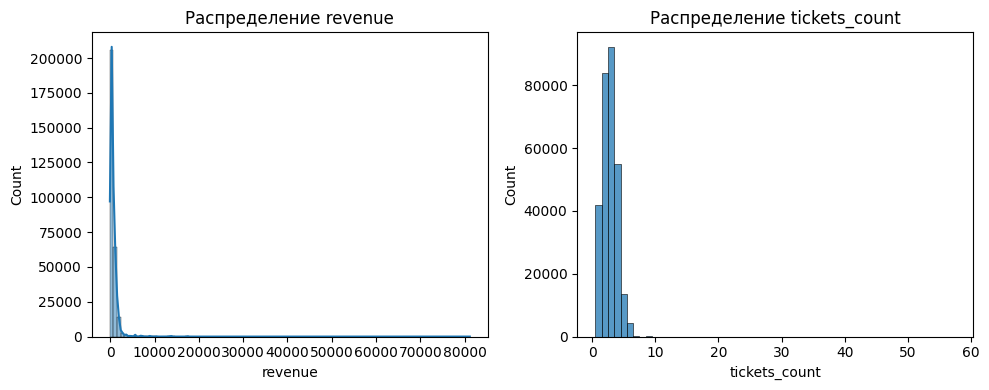

In [21]:
# Посмтроим гистограммы
plt.figure(figsize=(10, 4))

# Гистограмма revenue
plt.subplot(1, 2, 1)
sns.histplot(data=merged_df, x='revenue', bins=100, kde=True)
plt.title('Распределение revenue')

# Гистограмма tickets_count
plt.subplot(1, 2, 2)
sns.histplot(data=merged_df, x='tickets_count', bins=30, discrete=True)
plt.title('Распределение tickets_count')

plt.tight_layout()
plt.show()

В столбце `revenue` видны аномальные значения. Проверим этот столбец отдельно по валютам

In [22]:
# Проверка выбросов по валютам
rub_df = merged_df[merged_df['currency_code'] == 'rub']
kzt_df = merged_df[merged_df['currency_code'] == 'kzt']

In [23]:
print('RUB (revenue):')
print(rub_df['revenue'].describe())

print('\nKZT (revenue):')
print(kzt_df['revenue'].describe())

RUB (revenue):
count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

KZT (revenue):
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


Мы видим странное минимальное значение в рублях = -90. Это не нормально, проверим наличие выбросов на еще одной гистограмме

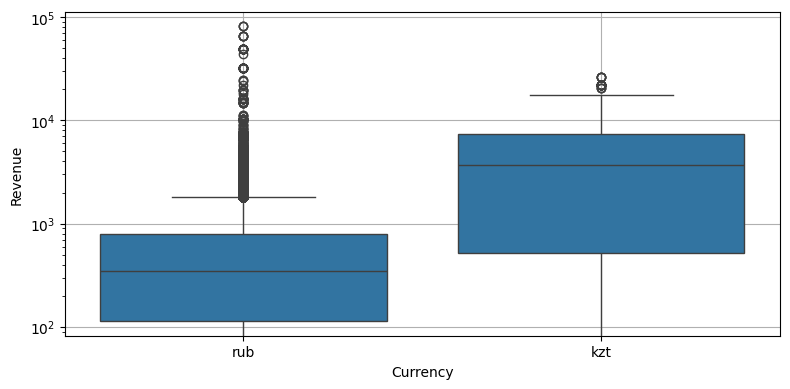

In [24]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=merged_df, x='currency_code', y='revenue')
plt.yscale('log')
plt.xlabel('Currency')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

Выбросы есть, их особенно много в валюте рубля, это скорее всего объясняется тем, что большее количество покупов билетов было сделано именно в рублях. Теперь отфильтруем выбросы по 99-му процентилю

In [25]:
# Отфильтруем выбросы по 99-му процентилю
# Получим 99-й перцентиль для каждой валюты
rub_99 = rub_df['revenue'].quantile(0.99)
kzt_99 = kzt_df['revenue'].quantile(0.99)
rub_trimmed = rub_df[rub_df['revenue'] <= rub_99]
kzt_trimmed = kzt_df[kzt_df['revenue'] <= kzt_99]

In [26]:
# Оставим строки других валют без изменений
other_df = merged_df[~merged_df['currency_code'].isin(['rub', 'kzt'])]

# Объединим всё обратно в merged_df
merged_df = pd.concat([rub_trimmed, kzt_trimmed, other_df], ignore_index=True)

Выбросы в `revenue` отфильтрованы по 99-му процентилю

### 2.4 Проверяем явные и неявные дубликаты

In [27]:
# Проверим явные дубликаты merged_df
duplicates_explicit = merged_df.duplicated()
print("Явных дубликатов:", duplicates_explicit.sum())

Явных дубликатов: 0


Явных дубликатов нет, удалять ничего не будем

In [28]:
# Список всех колонок, кроме order_id
cols_except_order_id = [col for col in merged_df.columns if col != 'order_id']

# Найдём неявные дубликаты по всем признакам, кроме order_id
duplicates_implicit = merged_df.duplicated(subset=cols_except_order_id, keep=False)

# Количество и доля неявных дубликатов
num_duplicates = duplicates_implicit.sum()
total_orders = len(merged_df)
share_duplicates = num_duplicates / total_orders

print(f"Неявных дубликатов по всем признакам (кроме order_id): {num_duplicates}")
print(f"Доля: {share_duplicates:.2%}")

Неявных дубликатов по всем признакам (кроме order_id): 58
Доля: 0.02%


Неявных дубликатов: всего 58, что составляет 0.02% от общего числа заказов. Это очень низкая доля, так что применим стратегию «удалить и оставить первое вхождение», что позволит повысить чистоту данных без искажения анализа

In [29]:
merged_df = merged_df.drop_duplicates(subset=cols_except_order_id, keep='first')

Проведена проверка неявных дубликатов по всем признакам, за исключением технического поля order_id.
Найдено 58 неявных дубликатов, что составляет лишь 0.02% от общего числа заказов.
Поскольку строки совпадают по всем остальным полям, было принято решение удалить дубликаты, оставив по одному представителю каждой группы. Это минимальное вмешательство позволяет повысить чистоту данных без искажения анализа.

### 2.5 Проверяем преобразование типов данных
При первичной проверке данных мы обратили внимание на то, что некоторые столбцы нужно поменять на тип даты и времени, поэтому поменяем их. Также проверим возможность снижения размерности количественных данных

In [30]:
# Посмотрим типы данных
print(merged_df.dtypes)

# Посмотрим использование памяти
merged_df.info(memory_usage='deep')

order_id                    int64
user_id                    object
created_dt_msk             object
created_ts_msk             object
event_id                    int64
cinema_circuit             object
age_limit                   int64
currency_code              object
device_type_canonical      object
revenue                   float64
service_name               object
tickets_count               int64
total                     float64
days_since_prev           float64
data                       object
nominal                   float64
curs                      float64
cdx                        object
event_name                 object
event_type_description     object
event_type_main            object
organizers                 object
region_name                object
city_name                  object
city_id                   float64
venue_id                  float64
venue_name                 object
venue_address              object
dtype: object
<class 'pandas.core.frame.DataFram

Данные занимают значительную часть памяти - почти 500 мегабайт, посмотрим, что можно сократить и переведем некоторые столбцы в тип даты и времени

In [31]:
# Преобразуем тип даты и времени
merged_df['created_dt_msk'] = pd.to_datetime(merged_df['created_dt_msk'], errors='coerce')
merged_df['created_ts_msk'] = pd.to_datetime(merged_df['created_ts_msk'], errors='coerce')
merged_df['data'] = pd.to_datetime(merged_df['data'], errors='coerce')

In [32]:
# Оптимизируем числовые типы
# int64 → int32
merged_df['order_id'] = pd.to_numeric(merged_df['order_id'], downcast='integer')
merged_df['event_id'] = pd.to_numeric(merged_df['event_id'], downcast='integer')
merged_df['age_limit'] = pd.to_numeric(merged_df['age_limit'], downcast='integer')
merged_df['tickets_count'] = pd.to_numeric(merged_df['tickets_count'], downcast='integer')

In [33]:
# float64 → float32
float_cols = ['revenue', 'total', 'days_since_prev', 'nominal', 'curs', 'city_id', 'venue_id']
for col in float_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], downcast='float')

In [34]:
# Проверим, насколько освободилась память
merged_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 287752 entries, 0 to 287781
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287752 non-null  int32         
 1   user_id                 287752 non-null  object        
 2   created_dt_msk          287752 non-null  datetime64[ns]
 3   created_ts_msk          287752 non-null  datetime64[ns]
 4   event_id                287752 non-null  int32         
 5   cinema_circuit          287752 non-null  object        
 6   age_limit               287752 non-null  int8          
 7   currency_code           287752 non-null  object        
 8   device_type_canonical   287752 non-null  object        
 9   revenue                 287752 non-null  float32       
 10  service_name            287752 non-null  object        
 11  tickets_count           287752 non-null  int8          
 12  total                   287752 non-

Заметно, что `total` и `revenue` остались с `float64`. Это может значит, что есть значения, которые не помещаются в `float32`, оставим их как есть. 
В остальных случаях мы поменяли `int64` на `int32`, `float64` на `float32`, а столбцы `created_dt_msk`, `created_ts_msk`, `data` привели к `datetime64`. Таким образом мы освободили память на 50 мегабайт

### 2.6 Создаем новые солбцы
- revenue_rub — приведем выручку с заказа к единой валюте — российскому рублю.
- one_ticket_revenue_rub — рассчитаем выручку с продажи одного билета на мероприятие.
- month — выделим месяц оформления заказа в отдельный столбец.
- season — создадим столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [35]:
# revenue_rub - выручка в рублях
# Переведем тенге в рубли, остальные оставим как есть
merged_df['revenue_rub'] = merged_df.apply(
    lambda row: row['revenue'] * (row['curs'] / 100) if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

In [36]:
# one_ticket_revenue_rub — выручка за один билет
merged_df['one_ticket_revenue_rub'] = merged_df.apply(
    lambda row: row['revenue_rub'] / row['tickets_count'] if row['tickets_count'] > 0 else None,
    axis=1
)

In [37]:
# month — месяц оформления заказа
merged_df['month'] = merged_df['created_ts_msk'].dt.month

In [38]:
# season — сезон
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'
    return None

merged_df['season'] = merged_df['month'].apply(get_season)

In [39]:
# Проверим результат
merged_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410034,463.470011,10,осень


Все получилось, мы создали новые столбцы

#### Промежуточный вывод
- Объединены датфреймы для удобства предоработки
- Проверены данные на пропуски
    - Их было 238, уникальных из них было 19 - незначительное количество, мы их удалили по столбцу `event_name`.  В столбце `days_since_prev` было 21940 пропусков, и, хоть с ними можно было ничего не делать, на всякий случай мы заменили их на 0.
- Изучены значения в ключевых столбцах
    - Были проверены категориальные значениях, критичных замечаний не было, ничего не заменили;
    - В количественных значениях были найдены выбросы в столбце `revenue`, мы отфильтровали их по 99-му процентилю.
- Проверены явные и неявные дубликаты
    - Явных дубликатов не выявлено;
    - Неявных дубликатов по бронированию билета без учёта идентификаторов заказа было выявлено 85, это 0,03% - незначительное кол-во. Был оставлен каждый первый дубликат в группе, остальные удалены.
- Проведено преобразование типов данных
    - Поменяли тип данных для столбцов с типом даты и времени;
    - Сократили память на 50 мегабайт, поменяв `int64` и `float64` на размер в 32. 
- Создано 4 новых столбца:
    - revenue_rub — выручка в рублях
    - one_ticket_revenue_rub — выручка за билет
    - month — номер месяца
    - season — сезон по месяцу


## 3. Исследовательский анализ данных
### 3.1 Анализ распределения заказов по сегментам и их сезонные изменения
- Для каждого месяца найдем количество заказов
- Для осеннего и летнего периодов сравним распределение заказов билетов
- Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью

#### 3.1.1 Кол-во заказов по месяцам (в целом)

In [40]:
# Считаем уникальные заказы по месяцам
orders_by_month = (
    merged_df
    .groupby('month')['order_id']
    .nunique()
    .reset_index()
    .sort_values('month')
)
print(orders_by_month)

   month  order_id
0      6     34164
1      7     40407
2      8     44550
3      9     69352
4     10     99279


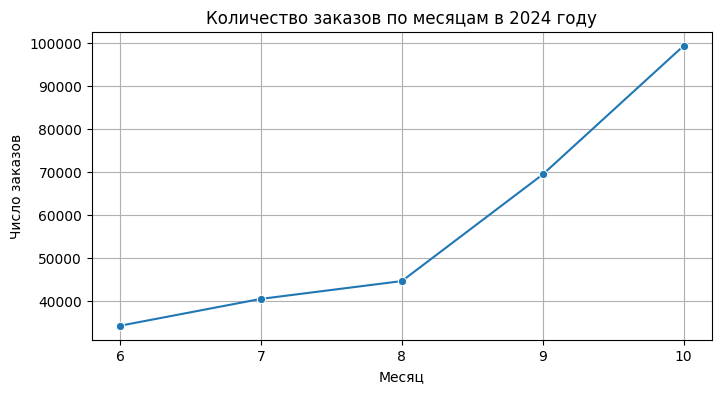

In [41]:
# Визуализация
plt.figure(figsize=(8, 4))
sns.lineplot(data=orders_by_month, x='month', y='order_id', marker='o')
plt.title('Количество заказов по месяцам в 2024 году')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.xticks(range(6, 11))
plt.grid(True)
plt.show()

Увеличение кол-ва заказов отчетливо видно: общее кол-во заказов увеличилось более чем в 2 раза с июня (34504) по ноябрь (100210). Теперь посмотрим кол-во заказов для каждого месяца по сегментам:

#### 3.1.2 Кол-во заказов для каждого месяца по типу мероприятия (event_type_main)

In [42]:
orders_by_event_type_month = (
    merged_df
    .groupby(['month', 'event_type_main'])['order_id']
    .nunique()
    .reset_index()
    .sort_values(['month', 'order_id'], ascending=[True, False])
)

display(orders_by_event_type_month)

,month,event_type_main,order_id
2,6,концерты,15489
1,6,другое,8864
5,6,театр,7354
4,6,стендап,1516
0,6,выставки,614
3,6,спорт,261
6,6,ёлки,66
9,7,концерты,16761
8,7,другое,11469
12,7,театр,8235


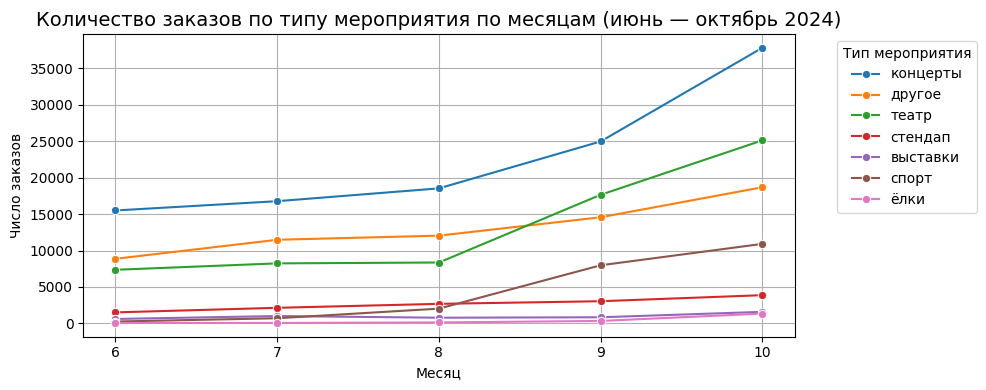

In [43]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    data=orders_by_event_type_month,
    x='month',
    y='order_id',
    hue='event_type_main',
    marker='o'
)

plt.title('Количество заказов по типу мероприятия по месяцам (июнь — октябрь 2024)', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.xticks([6, 7, 8, 9, 10])  # Только доступные месяцы
plt.legend(title='Тип мероприятия', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Концерты - безусловный лидер среди кол-ва заказов. Также можно отметить, что с августа по ноябрь возрасла популярность театров и заказов в категории спорт

#### 3.1.3 Кол-во заказов для каждого месяца по типу устройства (device_type_canonical)

In [44]:
orders_by_device_month = (
    merged_df
    .groupby(['month', 'device_type_canonical'])['order_id']
    .nunique()
    .reset_index()
    .sort_values(['month', 'order_id'])
)

display(orders_by_device_month)

,month,device_type_canonical,order_id
0,6,desktop,6860
1,6,mobile,27304
2,7,desktop,7899
3,7,mobile,32508
4,8,desktop,8301
5,8,mobile,36249
6,9,desktop,13389
7,9,mobile,55963
8,10,desktop,20914
9,10,mobile,78365


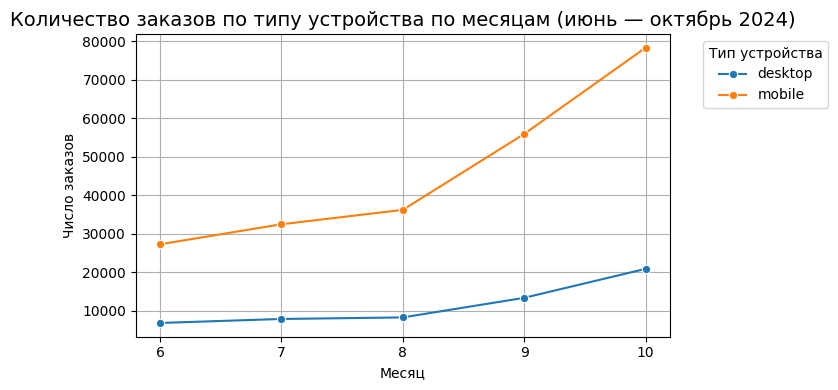

In [45]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=orders_by_device_month,
    x='month',
    y='order_id',
    hue='device_type_canonical',
    marker='o'
)

plt.title('Количество заказов по типу устройства по месяцам (июнь — октябрь 2024)', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.xticks([6, 7, 8, 9, 10])
plt.legend(title='Тип устройства', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Оформление заказа с помощью телефона намного популярнее, чем с компьютера. Можно заметить, что в обоих случаях кол-во заказов такде возросло с августа по ноябрь, однако заказы, сделанные при помощи телефона показывают значительно лучшую динамику - они возрасли примерно с 28000 до 80000, в то время как заказы с комьютера лишь с примерно 8000 до 210000

#### 3.1.4 Кол-во заказов для каждого месяца по возрастному рейтингу (age_limit)

In [46]:
orders_by_age_limit_month = (
    merged_df
    .groupby(['month', 'age_limit'])['order_id']
    .nunique()
    .reset_index()
    .sort_values(['month', 'order_id'])
)

display(orders_by_age_limit_month)

,month,age_limit,order_id
4,6,18,4606
0,6,0,5636
1,6,6,5986
2,6,12,8055
3,6,16,9881
5,7,0,6560
9,7,18,6592
7,7,12,7645
6,7,6,7831
8,7,16,11779


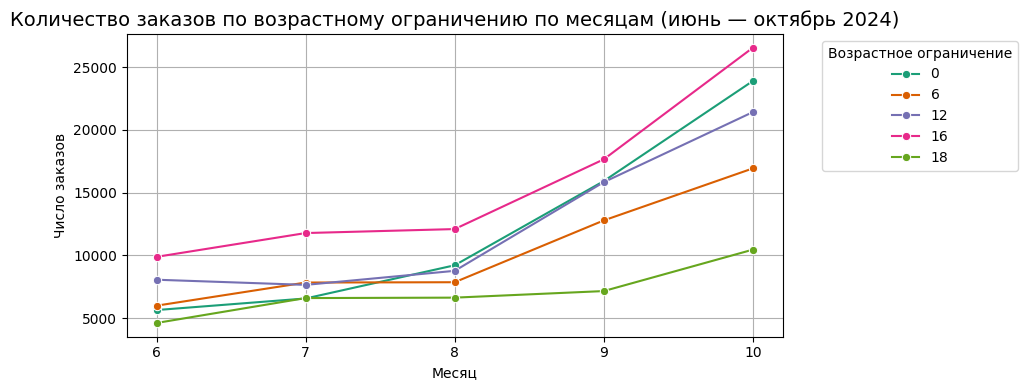

In [47]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    data=orders_by_age_limit_month,
    x='month',
    y='order_id',
    hue='age_limit',
    palette='Dark2',
    marker='o'
)

plt.title('Количество заказов по возрастному ограничению по месяцам (июнь — октябрь 2024)', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.xticks([6, 7, 8, 9, 10])
plt.legend(title='Возрастное ограничение', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

На этом графике встречается интересная тенденция: возрастной рейтинг 0+ обгоняет 12+ c сентября по октябрь. Лидер заказов - рейтинг 16+

#### 3.1.5 Сравнение распределения заказов билетов по разным категориям для осеннего и летнего периодов 

In [48]:
# Функция для подсчёта долей заказов
def compute_share(df, column):
    count_df = (
        df.groupby(['season', column])
        .size()
        .reset_index(name='count')
    )
    # Добавляем долю от общего числа заказов в сезоне
    count_df['share'] = count_df.groupby('season')['count'].transform(lambda x: x / x.sum())
    return count_df

In [49]:
# Применим функцию к каждому разрезу
event_type_share = compute_share(merged_df, 'event_type_main')
device_type_share = compute_share(merged_df, 'device_type_canonical')
age_limit_share = compute_share(merged_df, 'age_limit')

In [50]:
display(event_type_share)
display(device_type_share)
display(age_limit_share)

,season,event_type_main,count,share
0,лето,выставки,2416,0.020282
1,лето,другое,32369,0.271732
2,лето,концерты,50768,0.426188
3,лето,спорт,3006,0.025235
4,лето,стендап,6346,0.053274
5,лето,театр,23943,0.200997
6,лето,ёлки,273,0.002292
7,осень,выставки,2436,0.014446
8,осень,другое,33225,0.197028
9,осень,концерты,62740,0.372055


,season,device_type_canonical,count,share
0,лето,desktop,23060,0.193585
1,лето,mobile,96061,0.806415
2,осень,desktop,34303,0.203420
3,осень,mobile,134328,0.796580


,season,age_limit,count,share
0,лето,0,21404,0.179683
1,лето,6,21673,0.181941
2,лето,12,24464,0.205371
3,лето,16,33756,0.283376
4,лето,18,17824,0.149629
5,осень,0,39828,0.236184
6,осень,6,29720,0.176243
7,осень,12,37263,0.220974
8,осень,16,44217,0.262212
9,осень,18,17603,0.104388


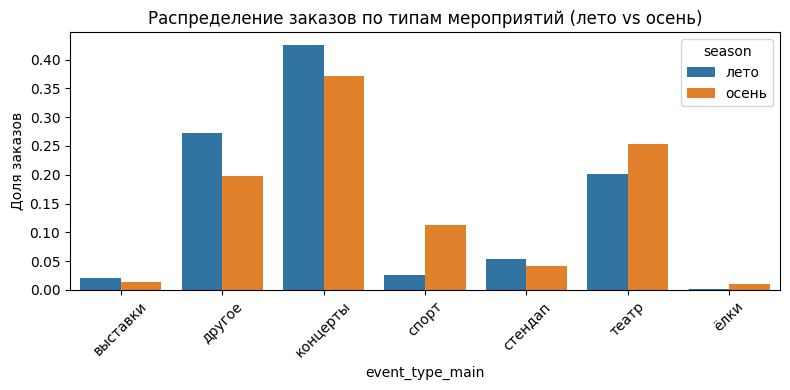

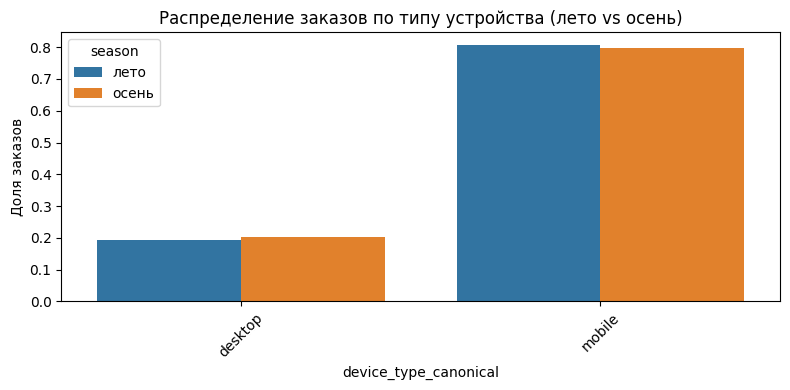

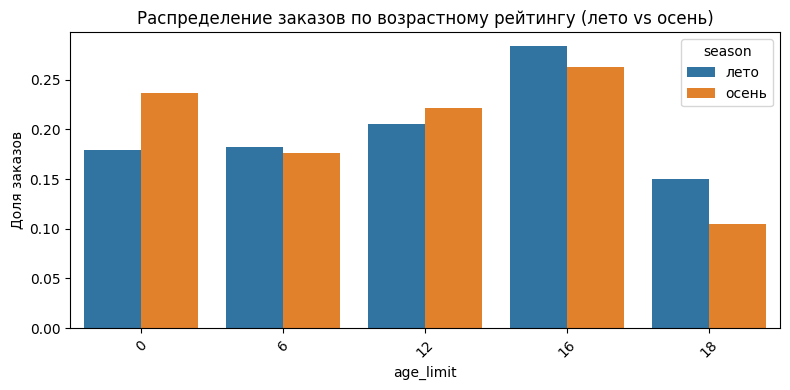

In [51]:
def plot_share(df, category_col, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x=category_col, y='share', hue='season')
    plt.title(title)
    plt.ylabel('Доля заказов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_share(event_type_share, 'event_type_main', 'Распределение заказов по типам мероприятий (лето vs осень)')
plot_share(device_type_share, 'device_type_canonical', 'Распределение заказов по типу устройства (лето vs осень)')
plot_share(age_limit_share, 'age_limit', 'Распределение заказов по возрастному рейтингу (лето vs осень)')

- В распределении заказов по типам мероприятий мы видим, что люди ходят на концерты чаще летом (40%), чем осенью (35%), также на следап и выставки. Однако в театр или на спорт покупатели предпочитают ходить осенью больше, чем летом. Осенью в театр ходят на 5% больше людей, чем летом;
- В распределении заказов по типу устройства почти незаметна разница между летом и осенью (около 2%), однако есть небольшие различия: клиенты, покупают билеты через компьютер, больше покупают осенью, а клиенты, покупающие билеты через телефон - летом. Это может говорить о том, что молодое поколение (пользующееся больше телефонами), активнее покупают билеты летом;
- В распределении заказов по типу устройства возрастному рейтингу больше всего билетов преобретают летом в рейтинге 16+ (28%), в остальных рейтингах покупки билетов летом относительно стабильны - около 25%. Осенью большиство билетов покупают с рейтингом 0+ и 12+.

#### 3.1.6 Изучение изменения выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью
Считаем по столбцу `one_ticket_revenue_rub`

In [52]:
# Отфильтруем лето и осень
df_season = merged_df[merged_df['season'].isin(['лето', 'осень'])]

In [53]:
# Посчитаем среднюю выручку с одного билета по типу мероприятия и сезону
# Группируем по сезону и типу мероприятия
agg_df = (
    df_season
    .groupby(['season', 'event_type_main'])
    .agg({'one_ticket_revenue_rub': 'mean'})
    .reset_index()
)

In [54]:
# Сделаем сводную табличку
pivot_df = agg_df.pivot(index='event_type_main', columns='season', values='one_ticket_revenue_rub').reset_index()

In [55]:
# Посчитаем относительное изменение 
pivot_df['relative_change_%'] = ((pivot_df['осень'] - pivot_df['лето']) / pivot_df['лето']) * 100

In [56]:
display(pivot_df)

season,event_type_main,лето,осень,relative_change_%
0,выставки,86.416197,90.603609,4.845633
1,другое,77.433968,76.115333,-1.702914
2,концерты,304.790309,268.358737,-11.952995
3,спорт,50.761831,49.969733,-1.560421
4,стендап,218.518107,231.124973,5.769255
5,театр,214.138855,175.969508,-17.824578
6,ёлки,271.436177,229.585590,-15.418205


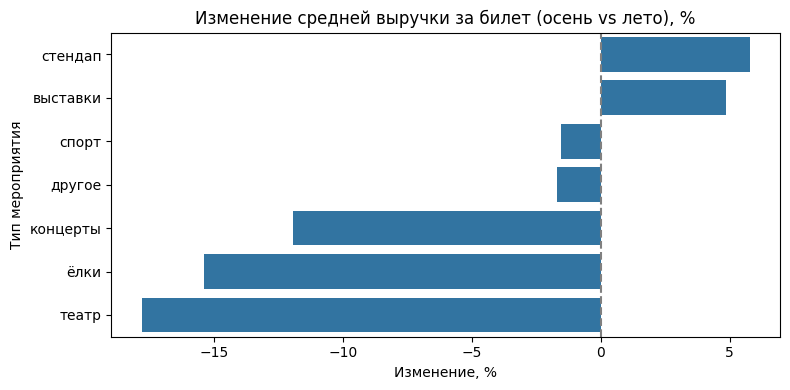

In [57]:
# Упорядочим по убыванию изменения
pivot_df = pivot_df.sort_values('relative_change_%', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=pivot_df, x='relative_change_%', y='event_type_main')
plt.title('Изменение средней выручки за билет (осень vs лето), %')
plt.xlabel('Изменение, %')
plt.ylabel('Тип мероприятия')
plt.axvline(0, color='gray', linestyle='--')  # линия нуля
plt.tight_layout()
plt.show()

На графике можно хорошо заметить, что осенью продажи билетов в театр упали на 17% относительно этих же продаж летом. Также упали продажи на ёлки (15%), концерты (10%), спорт (4%). Однако осенью увеличились продажи билетов на стендап (10%) и выставки (5%)

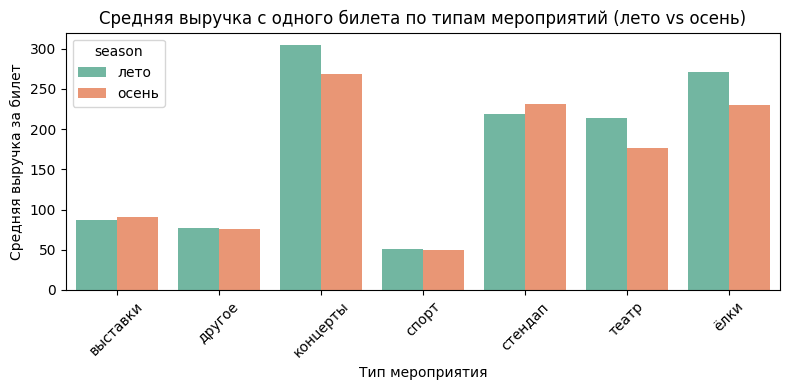

In [58]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=agg_df,
    x='event_type_main',
    y='one_ticket_revenue_rub',
    hue='season',
    palette='Set2'
)

plt.title('Средняя выручка с одного билета по типам мероприятий (лето vs осень)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя выручка за билет')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Средняя выручка с билетов на концерты выше летом (300), чем осенью(270), на ёлки тоже - летом 270, осенью 235. На остальные мероприятия сообтношение относительно одинаковое, но средняя выручка с билетов на стендап осенью больше, чем летом, а в театр наоборот - летом чуть больше, чем осенью. Выставки и спорт показывают почти одинаковый показатель в оба времени года

#### Промежуточный вывод
- Общая сезонная динамика заказов: С июня по ноябрь общее количество заказов выросло почти в 3 раза: с 34 504 до 100 210 заказов. Особенно активный рост начинается с августа, достигая пика в ноябре.
- Изменения по типам мероприятий (event_type_main):
    - Концерты остаются лидером по количеству заказов, но их доля снижается с 40% летом до 35% осенью. При этом средняя стоимость билета снижается на 10% — с 300₽ летом до 270₽ осенью.
    - Театр показывает снижение количества заказов осенью на 17%, а также снижение средней цены билета на 16%.
    - Спорт демонстрирует небольшой спад — около 4% по объему заказов и практически стабильную среднюю цену билета.
    - Стендап наоборот, осенью увеличивает как количество заказов, так и среднюю выручку на билет — примерно на 10%.
    - Выставки сохраняют стабильные показатели по заказам и средней стоимости билетов в оба сезона.
    - Ёлки теряют популярность и в количестве заказов, и в средней цене билета — снижение примерно на 15–17%.
- Изменения по типу устройства (device_type_canonical): Пользователи чаще оформляют заказы через телефон, чем через компьютер. Доля заказов с телефона остаётся высокой в обоих сезонах, но летом немного выше. Осенью заметнее рост заказов с компьютеров, что может отражать поведение старшей аудитории или корпоративные покупки.
- Изменения по возрастному рейтингу (age_limit): Лидирует категория 16+, особенно летом. Осенью увеличивается доля заказов с возрастным рейтингом 0+ и 12+ — это может быть связано с началом учебного года и семейными мероприятиями. Категория 0+ обгоняет 12+ с сентября по октябрь, особенно в осенние месяцы.

Таким образом, сезонность заметно влияет как на активность пользователей, так и на структуру спроса по категориям мероприятий.
Осенью покупатели меняют поведение: увеличивается интерес к театру, спорту и детским мероприятиям.

### 3.2 Осенняя активность пользователей
- Будем анализировать данные за Сентябрь и Октябрь
- Проанализируем динамику изменений по дням
- Изучим недельную цикличность

#### 3.2.1 Анализ динамики изменений по дням
Создадим сводную таблицу и сделаем линейный график по ее результатам

In [59]:
# Фильтруем сентябрь и октябрь 2024
fall_df = merged_df[
    (merged_df['created_dt_msk'].dt.year == 2024) &
    (merged_df['created_dt_msk'].dt.month.isin([9, 10]))
]

In [60]:
# Группировка по дате
daily_metrics = fall_df.groupby(fall_df['created_dt_msk'].dt.date).agg(
    orders=('user_id', 'count'),
    dau=('user_id', 'nunique'),
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')
).reset_index()

In [61]:
# Вычисляем производные показатели
daily_metrics['avg_orders_per_user'] = daily_metrics['orders'] / daily_metrics['dau']
daily_metrics = daily_metrics.rename(columns={'created_dt_msk': 'date'})

In [62]:
daily_metrics.head()

,date,orders,dau,avg_ticket_price,avg_orders_per_user
0,2024-09-01,1327,564,200.168708,2.352837
1,2024-09-02,1380,574,189.464640,2.404181
2,2024-09-03,5113,778,80.350151,6.571979
3,2024-09-04,1773,686,178.048069,2.584548
4,2024-09-05,1944,739,189.510156,2.630582


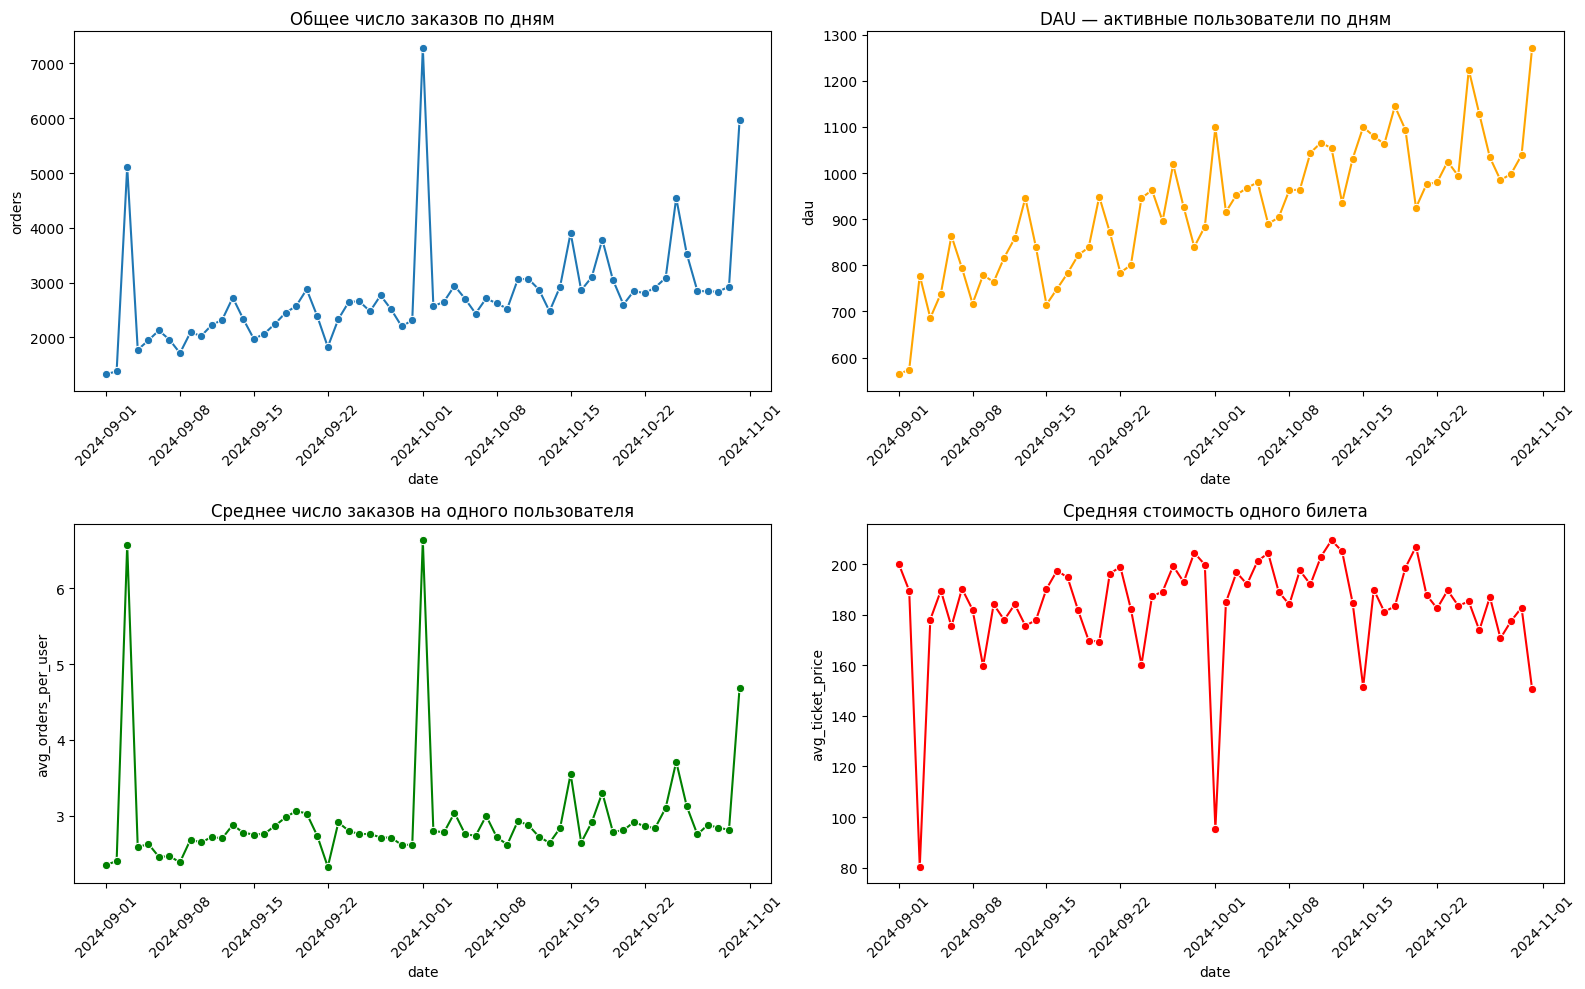

In [63]:
plt.figure(figsize=(16, 10))

# 1. Кол-во заказов
plt.subplot(2, 2, 1)
sns.lineplot(data=daily_metrics, x='date', y='orders', marker='o')
plt.title('Общее число заказов по дням')
plt.xticks(rotation=45)

# 2. DAU
plt.subplot(2, 2, 2)
sns.lineplot(data=daily_metrics, x='date', y='dau', marker='o', color='orange')
plt.title('DAU — активные пользователи по дням')
plt.xticks(rotation=45)

# 3. Среднее число заказов на пользователя
plt.subplot(2, 2, 3)
sns.lineplot(data=daily_metrics, x='date', y='avg_orders_per_user', marker='o', color='green')
plt.title('Среднее число заказов на одного пользователя')
plt.xticks(rotation=45)

# 4. Средняя стоимость билета
plt.subplot(2, 2, 4)
sns.lineplot(data=daily_metrics, x='date', y='avg_ticket_price', marker='o', color='red')
plt.title('Средняя стоимость одного билета')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Сильно выделяются 1 Сентября и 1 Октября - скорее всего в начале месяца были скидки на билетв, поэтому средння стоимость упала вниз, а общее число заказов и среднее на одного пользователя сильно поднялись вверх в эти дни. Также можно заметить, что число активных пользователей увеличивается за 3-5 дней, а затем резко падает. Это может быть связано с большой покупкой билетов в выходные дни и снижением спроса в будние дни, проверим это:

#### 3.2.2 Анализ недельной цикличности
Выделим день недели и сравним пользовательскую активность в будни и выходные.

In [64]:
# Добавим столбец с днем недели (0 — понедельник, 6 — воскресенье)
fall_df['weekday'] = fall_df['created_dt_msk'].dt.weekday
fall_df['weekday_name'] = fall_df['created_dt_msk'].dt.day_name()

# Добавим категорию: будни или выходные
fall_df['day_type'] = fall_df['weekday'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

/var/folders/ln/5hrdkhmx4nbgh8sd99qbvx0m0000gn/T/ipykernel_2955/2358773572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_df['weekday'] = fall_df['created_dt_msk'].dt.weekday
/var/folders/ln/5hrdkhmx4nbgh8sd99qbvx0m0000gn/T/ipykernel_2955/2358773572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_df['weekday_name'] = fall_df['created_dt_msk'].dt.day_name()
/var/folders/ln/5hrdkhmx4nbgh8sd99qbvx0m0000gn/T/ipykernel_2955/2358773572.py:6: SettingWithCopyWarning: 
A value is trying to be set 

In [65]:
orders_by_weekday = (
    fall_df.groupby('weekday_name')['order_id']
    .nunique()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])  # для порядка
)

print(orders_by_weekday)

weekday_name
Monday       21515
Tuesday      31490
Wednesday    22891
Thursday     27167
Friday       24835
Saturday     21342
Sunday       19391
Name: order_id, dtype: int64


/var/folders/ln/5hrdkhmx4nbgh8sd99qbvx0m0000gn/T/ipykernel_2955/1285022018.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_weekday.index, y=orders_by_weekday.values, palette="Set2")


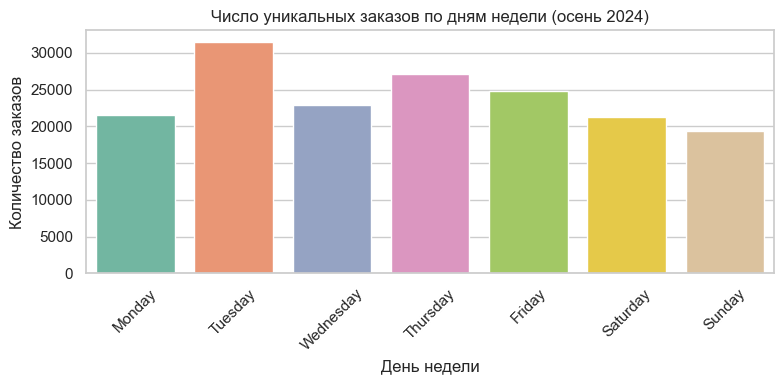

In [66]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x=orders_by_weekday.index, y=orders_by_weekday.values, palette="Set2")
plt.title('Число уникальных заказов по дням недели (осень 2024)')
plt.ylabel('Количество заказов')
plt.xlabel('День недели')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Пользователи делают больше заказов билетов во вторник (32тыс), потом идут четверг и пятница (около 27тыс). В выходные, как оказалось, пользовательская активность самая маленькая, как и по понедельникам (примерно 20тыс заказов). Сравним отдельные параменты по будним дням и вызодным:

In [67]:
# Количество заказов
orders_by_day_type = fall_df.groupby('day_type')['order_id'].nunique()
print(orders_by_day_type)

day_type
weekday    127898
weekend     40733
Name: order_id, dtype: int64


In [68]:
# Средняя выручка на одного пользователя
avg_revenue_by_day_type = fall_df.groupby('day_type')['one_ticket_revenue_rub'].mean()
print(avg_revenue_by_day_type)

day_type
weekday    172.754279
weekend    195.011063
Name: one_ticket_revenue_rub, dtype: float64


In [69]:
# Количество уникальных пользователей
users_by_day_type = fall_df.groupby('day_type')['user_id'].nunique()
print(users_by_day_type)

day_type
weekday    13217
weekend     7167
Name: user_id, dtype: int64


#### Промежуточный вывод
- В выходные количетво заказов меньше, чем в будни
- Больше всего заказов приходится на Четверг (около 32тыс)
- Средняя выручка на одного пользователя в выходные больше, чем в будни (204руб vs 183руб)
- Пользователи более активны в будние дни

Несмотря на то что активность полльзователей и число заказов больше в будние дни, средний чек на пользователя больше в выходные дни. Также стоит отметить, что за 2 месяца осени количество активных пользователей увеличивается с каждым днем, число заказов тоже идет вверх, стоимость одного билета относительно стабильна, иногда сильно падает вниз

### 3.3 Популярные события и партнёры
- Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов
- Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов

#### 3.3.1 Уникальное количество мероприятий и общее число заказов для каждого региона

In [70]:
# Группировка по региону: число мероприятий и заказов
region_stats = (
    fall_df
    .groupby('region_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'nunique')
    )
    .reset_index()
)

In [71]:
# Общие суммы по всем регионам
total_events_all = fall_df['event_id'].nunique()
total_orders_all = fall_df['order_id'].nunique()

In [72]:
# Доли
region_stats['event_share_%'] = (region_stats['unique_events'] / total_events_all * 100).round(2)
region_stats['order_share_%'] = (region_stats['total_orders'] / total_orders_all * 100).round(2)

In [73]:
# Сортировка по количеству уникальных мероприятий
region_stats = region_stats.sort_values('unique_events', ascending=False)

In [74]:
region_stats.head(10)

,region_name,unique_events,total_orders,event_share_%,order_share_%
23,Каменевский регион,3910,46684,24.63,27.68
59,Североярская область,2613,20718,16.46,12.29
75,Широковская область,803,8715,5.06,5.17
56,Светополянский округ,764,4779,4.81,2.83
51,Речиновская область,529,3565,3.33,2.11
60,Серебринская область,456,4467,2.87,2.65
76,Яблоневская область,432,4199,2.72,2.49
67,Тепляковская область,419,2485,2.64,1.47
11,Горицветская область,406,3230,2.56,1.92
63,Солнечноземская область,403,4228,2.54,2.51


Наибольшее разнообразие мероприятий предлагается в Каменевском регионе (24,6%) и в Североярской области (16%). Также на эти регионы приходится большая доля заказов - 27% и 12% соотвественно

#### 3.3.2 Число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов на каждого партнера

In [75]:
# Группировка по партнёрам
partners_df = (
    fall_df
    .groupby('service_name')
    .agg(
        unique_events=('event_id', 'nunique'),           # Сколько уникальных мероприятий
        total_orders=('order_id', 'count'),              # Сколько заказов
        total_revenue_rub=('revenue_rub', 'sum')         # Суммарная выручка
    )
    .reset_index()
)

In [76]:
# Значение выручки приведем к обычной форме записи из экспоненциальной с помощью round
partners_df['total_revenue_rub'] = partners_df['total_revenue_rub'].round(0)

In [77]:
# Общие суммы по всем партнёрам
total_events = partners_df['unique_events'].sum()
total_orders = partners_df['total_orders'].sum()
total_revenue = partners_df['total_revenue_rub'].sum()

In [78]:
# Доли
partners_df['event_share_%'] = (partners_df['unique_events'] / total_events * 100).round(2)
partners_df['order_share_%'] = (partners_df['total_orders'] / total_orders * 100).round(2)
partners_df['revenue_share_%'] = (partners_df['total_revenue_rub'] / total_revenue * 100).round(2)

In [79]:
# Сортируем по событиям
partners_df = partners_df.sort_values(by='unique_events', ascending=False)

In [80]:
partners_df.head(10)

,service_name,unique_events,total_orders,total_revenue_rub,event_share_%,order_share_%,revenue_share_%
21,Лови билет!,3616,25794,10381935.0,20.90,15.30,12.68
3,Билеты без проблем,2847,32405,12172563.0,16.46,19.22,14.86
5,Билеты в руки,2469,25728,7613383.0,14.27,15.26,9.30
25,Облачко,1409,15478,10611052.0,8.15,9.18,12.96
22,Лучшие билеты,1396,12432,1676010.0,8.07,7.37,2.05
24,Мой билет,1005,19416,10850676.0,5.81,11.51,13.25
30,Тебе билет!,859,3760,2166179.0,4.97,2.23,2.65
26,Прачечная,728,5798,2548310.0,4.21,3.44,3.11
8,Весь в билетах,599,9416,9351279.0,3.46,5.58,11.42
34,Яблоко,537,3473,2763332.0,3.10,2.06,3.37


Самый активный партнер - `Лови билет!` с 21% мероприятий, затем идет `Билеты без проблем` (16%) и `Билеты в руки` (14%). Однако по доле заказов лидирует партнер `Билеты без проблем` (19%). В топе по выручке можно заметить еще одного партнера - `Мой билет`, который не так активен (доля мероприятий лишь 5%), однако доля заказов и выручки хорошие - 11% и 13% соответственно

#### Промежуточный вывод

Регионы
- Каменевский регион — уверенный лидер как по числу уникальных мероприятий (24.6% от всех), так и по числу заказов (27%). Это говорит не только о большом культурном разнообразии, но и о высокой вовлечённости аудитории.
- Североярская область — вторая по значимости, обеспечивая 16% мероприятий и 12% заказов. Здесь наблюдается более скромное соотношение событий и заказов, что может указывать на менее плотное посещение отдельных мероприятий.
- Широковская область и Светополянский округ занимают третье и четвёртое места соответственно, но уже с заметно меньшими показателями: около 5% по обоим метрикам.
- Оставшиеся регионы из топ-10 дают от 2 до 3% всех мероприятий и заказов каждый. Это указывает на существенную концентрацию активности в нескольких регионах, при этом большинство остальных территорий показывают умеренные значения, что открывает возможности для развития новых локаций.

Партнёры по билетам
- Лови билет! и Билеты без проблем — два лидера по числу мероприятий (21% и 16%) и заказов (15% и 19%). Однако "Билеты без проблем" опережает по выручке, заняв 15% от всех продаж, несмотря на схожее число мероприятий.
- Облачко — выделяется высоким вкладом в выручку (13%) при сравнительно небольшом количестве заказов (9%) и событий (8%), что указывает на продажу более дорогих билетов или работу с эксклюзивными мероприятиями.
- Мой билет также интересен: лишь 6% событий, но почти 12% заказов и 13% выручки. Это может говорить о высокой повторной активности пользователей или удачном партнёрском позиционировании.
- Весь в билетах имеет умеренную долю заказов (5.6%), но сравнительно высокую выручку (11%), что может также указывать на более дорогие мероприятия в портфеле.
- Прочие партнёры занимают небольшие доли, а доля выручки у большинства из них не превышает 2–3%, что подчёркивает доминирование 3–4 ключевых игроков на рынке.

Распределение активности по регионам и партнёрам неоднородно. Чётко выражены ключевые центры активности (Каменевский и Североярская регионы) и лидирующие партнёры — такие как Билеты без проблем, Облачко, Мой билет. Эти категории обеспечивают основной объём заказов и выручки, в то время как остальные регионы и компании имеют заметно меньший вклад.

## 4. Статистический анализ данных
Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств
Будем использоать данные только за осенний период.

### 4.1 Гипотеза 1
- Нулевая гипотеза H0: Среднее количество заказов на одного пользователя мобильных устройств равно среднему количеству заказов на одного пользователя стационарных устройств.
- Альтернативная гипотеза H1: Среднее количество заказов на одного пользователя мобильных устройств больше, чем у стационарных.

В обоих случаях (для гипотез о количестве заказов и интервале между заказами) были выбраны непараметрические тесты Манна-Уитни, так как:

- Распределения имеют значительное количество выбросов и выраженную асимметрию. Это видно на распределениях (например, через boxplot), и в таких ситуациях среднее значение может быть неустойчиво к экстремальным значениям.
- Мы сравниваем две независимые выборки (пользователи мобильных и стационарных устройств), при этом данные не агрегированы в сбалансированные группы, а разброс значений и наличие "тяжёлого хвоста" может искажать результат параметрических тестов.
- Манна-Уитни более устойчив к выбросам и асимметрии и позволяет сравнивать не столько средние, сколько положение распределений относительно друг друга, что в контексте пользовательской активности (кол-во заказов, время между ними) даёт более надёжный результат.

Использование параметрических тестов вроде t-test с поправкой Уэлча теоретически допустимо, но в данном случае данные не соответствуют условиям его корректной работы из-за наличия выбросов и нарушенной симметрии.

In [81]:
# Считаем количество заказов на пользователя и устройство
orders_per_user_device = fall_df.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index(name='order_count')

In [82]:
# Разделяем на две группы
mobile_orders = orders_per_user_device[orders_per_user_device['device_type_canonical'] == 'mobile']['order_count']
desktop_orders = orders_per_user_device[orders_per_user_device['device_type_canonical'] == 'desktop']['order_count']

In [83]:
# Выполним тест Манна-Уитни
stat_u, p_value = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

print(f"Mann-Whitney U statistic: {stat_u}")
print(f"P-value (alternative='greater'): {p_value:.4f}")

if p_value < 0.05:
    print("Отвергаем H0: среднее количество заказов у мобильных пользователей статистически выше.")
else:
    print("Нет оснований отвергать H0: статистически значимой разницы нет.")

Mann-Whitney U statistic: 36111903.0
P-value (alternative='greater'): 0.0000
Отвергаем H0: среднее количество заказов у мобильных пользователей статистически выше.


Отвергаем нулевую гипотезу, потому что Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств. Вывод: Первая гипотеза, которую нужно было проверить по заданию, верна

### 4.2 Гипотеза 2
- Нулевая гипотеза Н0: Среднее время между заказами у мобильных пользователей равно среднему времени у пользователей стационарных утройств.
- Альтернативная гипотеза Н1: Среднее время между заказами у мобильных пользователей больше, чем у пользователей стационарных устройств.

In [84]:
# Берём значения days_since_prev для мобильных и стационарных утройств
mobile_days = fall_df[(fall_df['device_type_canonical'] == 'mobile')]['days_since_prev'].dropna()
desktop_days = fall_df[(fall_df['device_type_canonical'] == 'desktop')]['days_since_prev'].dropna()

In [85]:
stat_u, p_value = mannwhitneyu(mobile_days, desktop_days, alternative='greater')

print(f"Mann-Whitney U statistic: {stat_u}")
print(f"P-value (alternative='greater'): {p_value:.4f}")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: время между заказами у мобильных пользователей статистически больше.")
else:
    print("Нет оснований отвергать нулевую гипотезу: статистически значимой разницы нет.")

Mann-Whitney U statistic: 2220608137.0
P-value (alternative='greater'): 0.0000
Отвергаем нулевую гипотезу: время между заказами у мобильных пользователей статистически больше.


Отвергаем нулевую гипотезу, потому что среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств. Вывод: Вторая гипотеза, которую нужно было проверить по заданию, верна

#### Промежуточный вывод
Первая гипотеза:
- Среднее количество заказов на одного пользователя мобильного приложения значительно выше, чем у пользователей стационарных устройств.
- Статистический тест Манна-Уитни дал p-value = 0.0000 (значительно меньше 0.05).
- Это означает, что нулевая гипотеза отвергается — различия статистически значимы.
- Следовательно, мобильные пользователи действительно делают в среднем больше заказов.

Вторая гипотеза:
- Среднее время между заказами пользователей мобильных приложений выше, чем у пользователей стационарных устройств.
- Результаты теста Манна-Уитни также показывают p-value = 0.0000.
- Нулевая гипотеза отвергается — мобильные пользователи в среднем дольше ждут между заказами, чем десктопные.
- Это может указывать на специфику поведения мобильных пользователей: они делают больше заказов, но с более длительными интервалами.

Обе гипотезы подтверждены статистически значимыми результатами тестов Манна-Уитни. Это говорит о различиях в поведении мобильных и десктопных пользователей — мобильные делают больше заказов, но при этом с большим средним временем между ними.

## 5. Общий вывод и рекомендации
**Данные**
- В работе использованы объединённые данные по заказам билетов на мероприятия за 2024 год с различной дополнительной информацией: тип устройства пользователя, сезонность, возрастные ограничения, регион, партнёры по билетам, выручка в рублях и другие параметры. Данные предварительно очищены от пропусков и дубликатов, приведены к корректным типам, рассчитаны новые показатели для удобства анализа.

**Основные результаты анализа**
- Популярность мероприятий: Концерты сохраняют лидерство по количеству заказов, но с осенним снижением доли и средней стоимости билета. Театр и спорт демонстрируют умеренный спад, тогда как стендап и детские мероприятия осенью набирают популярность. Ёлки и праздничные мероприятия теряют интерес аудитории.
- Сезонные изменения: Количество заказов выросло почти в 3 раза с июня по ноябрь, что отражает сильную сезонность и активность осеннего периода. В выходные дни активность ниже, но средний чек выше, что указывает на более дорогие покупки.
- Региональная и партнёрская активность: Каменевский регион и Североярская область — ключевые регионы по количеству заказов и мероприятий. Среди партнёров лидируют «Билеты без проблем», «Лови билет!» и «Облачко», обеспечивающие значительную долю выручки и заказов.
- Поведение пользователей: Пользователи мобильных устройств делают больше заказов, но с более длительными интервалами между ними по сравнению с десктопными пользователями. Это указывает на различия в привычках и, возможно, разные сценарии использования приложений.

**Результаты проверки гипотез**
- Гипотеза 1: Среднее количество заказов у мобильных пользователей статистически выше, чем у пользователей стационарных устройств — подтверждена.
- Гипотеза 2: Среднее время между заказами у мобильных пользователей статистически выше, чем у десктопных — также подтверждена.
- Обе гипотезы подтверждают значимые различия в пользовательском поведении между мобильными и стационарными устройствами.

**Рекомендации**
- Фокус на мобильных пользователях: поскольку они более активны в количестве заказов, стоит продолжать улучшать мобильный опыт, стимулировать частоту покупок (например, через персонализированные предложения и уведомления).
- Исследовать причины долгих интервалов между заказами у мобильных пользователей: возможно, полезно изучить, какие факторы влияют на паузы и как их сократить.
- Сезонные маркетинговые кампании: активировать промо в пиковые осенние месяцы, с акцентом на растущие категории — стендап и детские мероприятия.
- Региональная сегментация: развивать предложения в ключевых регионах с большим потенциалом (Каменевский и Североярская), а также рассмотреть возможности расширения в менее активных регионах.
- Работа с партнёрами: усилить сотрудничество с ведущими билетными операторами, оптимизировать цены и ассортимент билетов, учитывая их вклад в выручку.
- Анализ поведения по дням недели: учесть разницу в активности и среднем чеке между буднями и выходными при планировании акций и событий.